Bandpass (rows-as-time): 0.1–15.0 Hz @ fs=50.355 Hz | order 4

Processing: data_displaid_tidal\data_tilda_transformed\Data Raw Voltage apnea\TDL010_voltage_apnea.csv
  Saved CSV → data_displaid_tidal\data_tilda_transformed\Data Raw Voltage apnea filtered\TDL010_voltage_apnea.csv

Processing: data_displaid_tidal\data_tilda_transformed\Data Raw Voltage apnea\TDL012_voltage_apnea.csv
  Saved CSV → data_displaid_tidal\data_tilda_transformed\Data Raw Voltage apnea filtered\TDL012_voltage_apnea.csv

Processing: data_displaid_tidal\data_tilda_transformed\Data Raw Voltage apnea\TDL013_voltage_apnea.csv
  Saved CSV → data_displaid_tidal\data_tilda_transformed\Data Raw Voltage apnea filtered\TDL013_voltage_apnea.csv

Processing: data_displaid_tidal\data_tilda_transformed\Data Raw Voltage apnea\TDL014_voltage_apnea.csv
  Saved CSV → data_displaid_tidal\data_tilda_transformed\Data Raw Voltage apnea filtered\TDL014_voltage_apnea.csv

Processing: data_displaid_tidal\data_tilda_transformed\Data Raw V

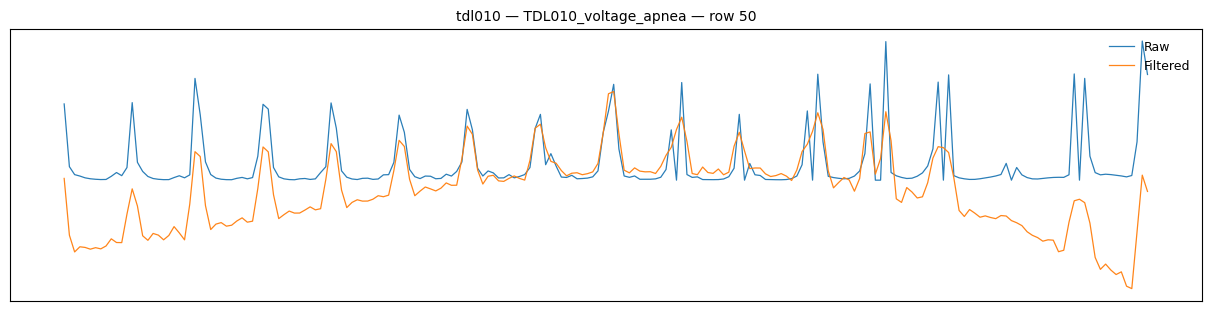

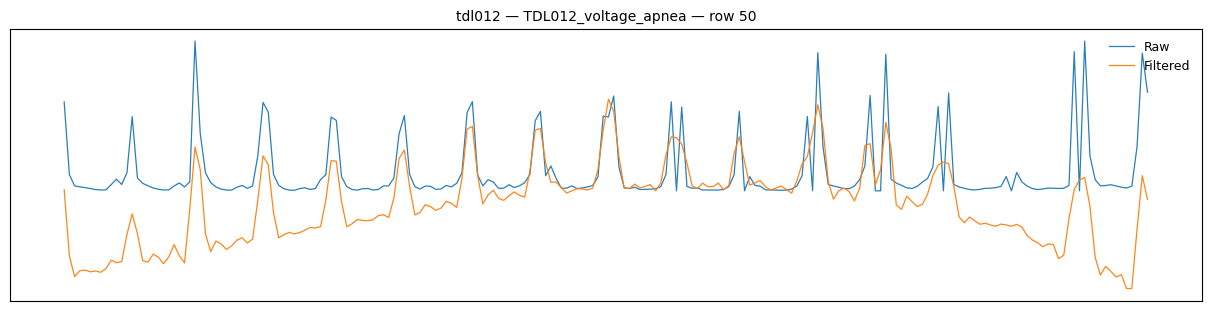

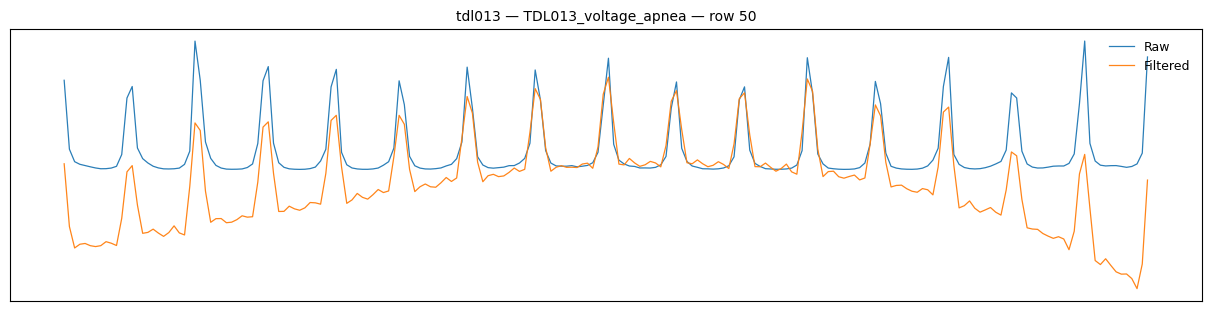

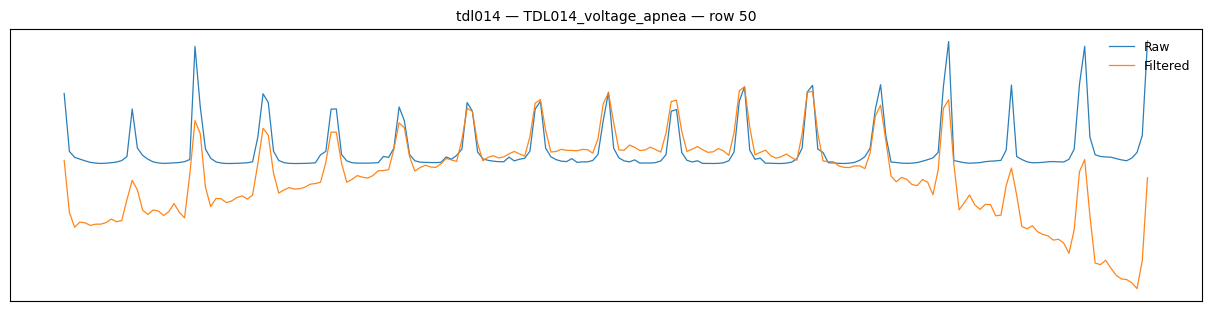

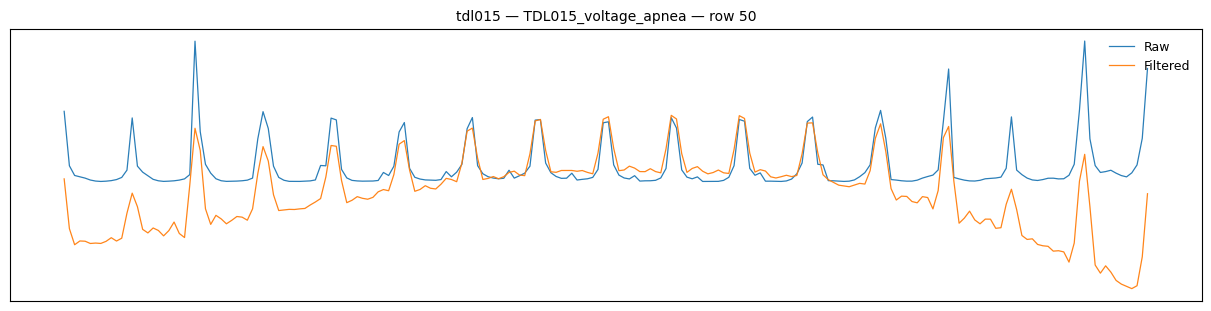

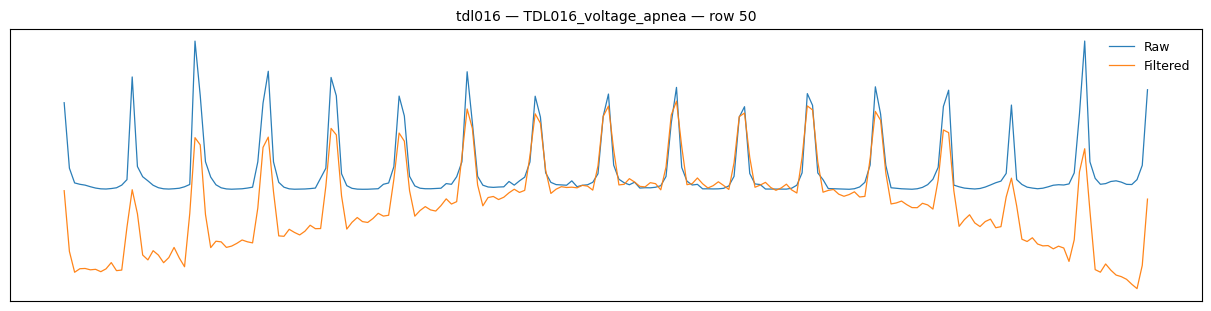


Done.


In [3]:
import os
import re
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfiltfilt, detrend

# ============================== CONFIG ======================================
IN_FOLDER     = r"data_displaid_tidal\data_tilda_transformed\Data Raw Voltage apnea"
OUT_FOLDER    = r"data_displaid_tidal\data_tilda_transformed\Data Raw Voltage apnea filtered"

FS            = 50.355   # sampling rate (Hz)
LOWCUT        = 0.1      # bandpass low cut (Hz)
HIGHCUT       = 15.0      # bandpass high cut (Hz)
ORDER         = 4        # Butterworth order (effective doubled by filtfilt)

ROW_TO_PLOT   = 50     # None -> default to 1; otherwise provide 1-indexed row number
PLOT_SAMPLES  = 208      # number of time samples to display (columns)
# ============================================================================


# -------------------------- Filtering Helpers -------------------------------
def butter_bandpass_sos(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    if not (0 < low < high < 1):
        raise ValueError(f"Bad band: low={lowcut} high={highcut} with fs={fs} (nyquist={nyq})")
    return butter(order, [low, high], btype="band", output="sos")


def apply_bandpass_rows_as_time(df, lowcut, highcut, fs, order=4):
    """
    Band-pass filter assuming **time across columns** (axis=1) and
    each row = one acquisition.
    Returns a DataFrame with the same shape.
    """
    X = df.to_numpy(dtype=np.float32, copy=False)
    L = X.shape[1]  # number of time samples per acquisition

    if L < 10:
        # Too few samples to filtfilt meaningfully; just de-mean per row.
        X0 = X - np.mean(X, axis=1, keepdims=True)
        return pd.DataFrame(X0)

    # remove DC offset per row to reduce edge transients
    X = detrend(X, axis=1, type="constant")

    sos = butter_bandpass_sos(lowcut, highcut, fs, order=order)

    # safe padlen for sosfiltfilt (function of number of biquad sections) but <= L-1
    sections = sos.shape[0]
    padlen = min(int(6 * sections), L - 1)

    Y = sosfiltfilt(sos, X, axis=1, padlen=padlen)
    return pd.DataFrame(Y)


# --------------------------- Amplitude metrics ------------------------------
def amplitude_metrics(row: np.ndarray):
    """Return peak-to-peak and RMS amplitude for a 1D array."""
    p2p = float(np.nanmax(row) - np.nanmin(row))
    rms = float(np.sqrt(np.nanmean(row**2)))
    return p2p, rms


# ----------------------------- Plotting -------------------------------------
def plot_row_overlay(df_raw, df_filt, row_1indexed=1, title_prefix=""):
    """
    Overlay the selected ROW (1-indexed) raw vs filtered on one axis.
    Shows exactly the first PLOT_SAMPLES samples (or fewer if shorter).
    No ticks/grid/axis labels; includes a legend.
    """
    Xr = df_raw.to_numpy(dtype=np.float32, copy=False)
    Xf = df_filt.to_numpy(dtype=np.float32, copy=False)

    idx = (row_1indexed or 1) - 1  # allow None -> 1
    if idx < 0 or idx >= Xr.shape[0]:
        print(f"  [warn] Requested row {row_1indexed} not available (n_rows={Xr.shape[0]}). Skipping plot.")
        return

    nshow = min(PLOT_SAMPLES, Xr.shape[1], Xf.shape[1])
    fig, ax = plt.subplots(figsize=(12, 3), constrained_layout=True)
    ax.plot(Xr[idx, :nshow], linewidth=0.9, alpha=0.95, label="Raw")
    ax.plot(Xf[idx, :nshow], linewidth=0.9, alpha=0.95, label="Filtered")
    ax.set_xticks([]); ax.set_yticks([])
    if title_prefix:
        ax.set_title(title_prefix, fontsize=10, pad=6)
    ax.legend(loc="upper right", fontsize=9, frameon=False)
    plt.show()


# ---------------------- Patient / Acquisition Helpers -----------------------
def natural_sort_key(path):
    """Natural sort key for filenames with numbers."""
    name = os.path.basename(path)
    return [int(s) if s.isdigit() else s.lower() for s in re.split(r'(\d+)', name)]

def infer_patient_id(path):
    """
    Infer a patient ID from filename.
    Matches: patientXX / patXX / ptXX / pXX (underscores/dashes/space OK).
    Fallback: first token before '_' or '-'.
    """
    name = os.path.splitext(os.path.basename(path))[0]
    m = re.search(r'(?:^|[_\-])(?:patient|pat|pt|p)\s*0*([0-9]+)', name, re.IGNORECASE)
    if m:
        return f"patient{int(m.group(1)):03d}"
    return re.split(r'[_\-]', name)[0].lower()


# --------------------------------- Main -------------------------------------
def main():
    os.makedirs(OUT_FOLDER, exist_ok=True)

    csv_files = glob.glob(os.path.join(IN_FOLDER, "*.csv"))
    if not csv_files:
        print("No CSV files found.")
        return

    print(f"Bandpass (rows-as-time): {LOWCUT}–{HIGHCUT} Hz @ fs={FS} Hz | order {ORDER}")

    # Pick the earliest/natural-sorted file per patient for plotting
    first_file_for_patient = {}
    for fp in sorted(csv_files, key=natural_sort_key):
        pid = infer_patient_id(fp)
        if pid not in first_file_for_patient:
            first_file_for_patient[pid] = fp

    # Collect amplitudes for all acquisitions (rows) of all files
    amp_rows = []  # list of dicts

    # Pass 1: process all files (filter + save + compute amplitudes per row)
    for fp in sorted(csv_files, key=natural_sort_key):
        print(f"\nProcessing: {fp}")
        df_raw = pd.read_csv(fp, header=None)

        # Ensure all numeric
        if not all(np.issubdtype(dt, np.number) for dt in df_raw.dtypes.values):
            raise ValueError(f"{fp}: non-numeric columns found (expected all numeric).")

        # Filter with time along columns
        df_filt = apply_bandpass_rows_as_time(df_raw, LOWCUT, HIGHCUT, FS, order=ORDER)

        # Save filtered CSV (keeps originals untouched)
        out_csv = os.path.join(OUT_FOLDER, os.path.basename(fp))
        df_filt.to_csv(out_csv, header=False, index=False)
        print(f"  Saved CSV → {out_csv}")

        # Amplitude per acquisition row (before & after)
        Xr = df_raw.to_numpy(dtype=np.float32, copy=False)
        Xf = df_filt.to_numpy(dtype=np.float32, copy=False)
        pid = infer_patient_id(fp)
        fname = os.path.basename(fp)
        nrows = Xr.shape[0]

        for r in range(nrows):
            p2p_raw, rms_raw = amplitude_metrics(Xr[r, :])
            p2p_flt, rms_flt = amplitude_metrics(Xf[r, :])
            amp_rows.append({
                "patient_id": pid,
                "file_name": fname,
                "acq_row_1indexed": r + 1,
                "p2p_raw": p2p_raw,
                "p2p_filtered": p2p_flt,
                "rms_raw": rms_raw,
                "rms_filtered": rms_flt
            })

    # Save amplitude summary
    if amp_rows:
        amp_df = pd.DataFrame(amp_rows)
        amp_csv = os.path.join(OUT_FOLDER, "amplitude_summary.csv")
        amp_df.to_csv(amp_csv, index=False)
        print(f"\nAmplitude summary saved → {amp_csv}")

    # Pass 2: for each patient, plot selected row (default row 1) from first file only
    row_to_plot = ROW_TO_PLOT or 1
    print(f"\nPlotting row #{row_to_plot} per patient (from first file):")
    for pid in sorted(first_file_for_patient.keys()):
        fp = first_file_for_patient[pid]
        df_raw = pd.read_csv(fp, header=None)
        df_filt = pd.read_csv(os.path.join(OUT_FOLDER, os.path.basename(fp)), header=None)
        title = f"{pid} — {os.path.splitext(os.path.basename(fp))[0]} — row {row_to_plot}"
        plot_row_overlay(df_raw, df_filt, row_1indexed=row_to_plot, title_prefix=title)

    print("\nDone.")


if __name__ == "__main__":
    main()
